In [34]:
import time
import ctypes
import xarray as xr
import aggfly
import numpy as np
from aggfly import regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from dask.cache import Cache

cache = Cache(10e9)  # Leverage two gigabytes of memory
cache.register()    # Turn cache on globally

ProgressBar().register()

import geopandas as gpd

In [2]:
# Set file output name/path
output_path = "/home3/dth2133/data/aggregated/counties/"
output_name = "usa_counties_corn_monthly"
output_varn = "dd"
csv = True

In [41]:
# Open shapefile containing region features.
georegions = regions.from_name('counties')

# Open example climate dataset to calculate grid weights.
clim = dataset.from_path(
    f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand2019.zarr", 
    't2m', 
    'zarr', 
    preprocess=dataset.timefix_era5l)

# Clip climate data to the US (raw data are global)
clim.clip_data_to_georegions_extent(georegions)

# Rechunk dataset to optimize multithreading
clim.rechunk(-1)

# Calculate area and crop layer weights.
weights = grid_weights.from_objects(clim, georegions, crop=None)

# This object aggregates cells within a region to the average across 
# cells, weighted by `weights`, which in this case are the area of the
# cell and the share of the cell with corn crops.
spatial = SpatialAggregator('avg')

# This object covers aggregating hourly and daily data to the yearly 
# level
temps = range(30,31)
daily = [TemporalAggregator(
    'dd',
    agg_from='hour',
    agg_to='day', 
    ddargs=[x,999,0]) for x in temps]

monthly = TemporalAggregator(
    'sum', 
    agg_from='day',
    agg_to='month')

# Years to aggregate
years = np.arange(2018,2019)

In [24]:
# Calculate the grid weights

# Loading from disk to save a couple minutes
# w.rename('weights').to_dataset().to_netcdf('CILads_testweights.nc')
w = xr.open_dataset('CILads_testweights.nc')['weights']

# Usually do this!
# w = weights.weights()
w = w.chunk((-1))

<AxesSubplot:title={'center':'region = 36059'}, xlabel='longitude', ylabel='latitude'>

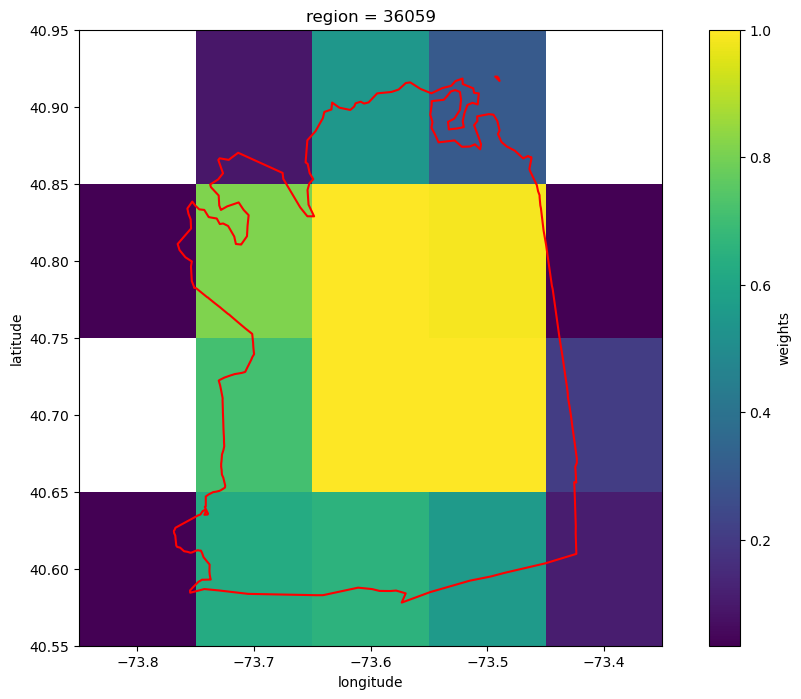

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
(nassau
     .rename({'lat':'latitude', 'lon':'longitude'})
     .where(nassau>0, drop = True).plot(ax = ax) )
georegions.plot_region('36059', ax=ax, color='red')

In [32]:
def run_era5l_agg(year, region):
    # This function performs the actual aggregation for a single year, region.
    # Note that this function runs "lazily", i.e., returns an object that is
    # passed on to Dask for computation.
    
    # Open climate dataset.
    clim = dataset.from_path(
        f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand2019.zarr", 
        var = 't2m', 
        engine = 'zarr', 
        preprocess=dataset.timefix_era5l)
    clim.rechunk(-1)

    # Spatial agregation
    agg_clim = spatial.map_execute(clim, w)

    # Temporal aggregation
    daily_list = [x.map_execute(agg_clim) for x in daily]
    monthly_list = [monthly.map_execute(x, update=True) for x in daily_list]

    # Return only the dask dataframes from the Datset objects
    return [x.da.data for x in monthly_list]

In [39]:
print('AGGREGATING YEARS')
output_list = list()
time_list = list()
for year in years:
    print(year)

    # Start timing
    start = time.time()
    time_list.append(year)

    # Aggregate this year, region & append to list
    output_list.append(dask.compute(run_era5l_agg(year, georegions))[0])

    # Report timing
    stop = time.time()
    duration = stop-start
    print(round(duration/60,2))

AGGREGATING YEARS
2018
[########################################] | 100% Completed | 21.97 s
[########################################] | 100% Completed | 21.99 s
0.37


In [43]:
print('COMBINING OUTPUT')
# Put everything together in one dataset
d_list = list()
for t in range(len(temps)):
    y_list = list()
    for y in range(len(years)):
        # print(y)
        y_list.append(xr.DataArray(
            data = output_list[y][t],
            dims = ['region', 'year', 'month'],
            coords = dict(
                regioni=('region', georegions.regions),
                year = ('year', [years[y]]),
                month = ('month', np.arange(1,13))
            ),
            name = f'time{temps[t]}'
        ))
    d_list.append(xr.concat(y_list, dim='year'))

COMBINING OUTPUT


In [44]:
# Save
ds = xr.combine_by_coords(d_list)    
ds.to_netcdf(f'/home3/dth2133/data/CIL_lads_demo.nc4')

In [ ]:
ds.sel.region

<xarray.Dataset>
Dimensions:  (region: 3108, year: 1, month: 12)
Coordinates:
    regioni  (region) object '21007' '21017' '21031' ... '48171' '55079' '26139'
  * year     (year) int64 2018
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: region
Data variables:
    time30   (region, year, month) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [ ]:
aclim = spatial.map_execute(clim, w)
daily_list = [x.map_execute(aclim) for x in daily]
annual_list = [annual.map_execute(x, update=True) for x in daily_list]

In [6]:
result = dask.compute([x.da for x in annual_list])

[########################################] | 100% Completed | 35.2s


### Multi-year

In [7]:
def aggregate_era5l_t2m_multi(path):
    
    # path = "/home3/dth2133/data/usa/usa-t2m_tempPrecLand1969.zarr"
    # Open climate dataset.
    clim = dataset.from_path(
        path, 
        't2m', 
        'zarr', 
        preprocess=dataset.timefix_era5l) # Kelvin to Celsius
    
    # Clip climate data to the US (raw data are global)
    clim.clip_data_to_georegions_extent(georegions)
    # Rechunk dataset to optimize multithreading
    clim.rechunk((5, 578, -1, -1, -1))
    
    daily_list = [x.map_execute(clim.da.data) for x in daily]
    annual_list = [annual.map_execute(x) for x in daily_list]
    rc_list = [x.rechunk(-1) for x in annual_list]
    spatial_list = [spatial.map_execute(x, w) for x in rc_list]
    
    return spatial_list
    

In [8]:
# Check years from the input path - this just creates a vector of years for
# which my raw climate data are available, e.g. [1970, 1971, ...]
import numpy as np
import glob
from os.path import basename
files = np.sort([x for x in glob.glob('/home3/dth2133/data/usa/*t2m_*')])
# Loop over years and aggregate.
output = list()
for f in files:
    print(f)
    output.append(aggregate_era5l_t2m_multi(f))

/home3/dth2133/data/usa/usa-t2m_tempPrecLand1951.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1952.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1953.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1954.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1955.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1956.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1957.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1958.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1960.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1961.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1962.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1963.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1964.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1965.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1966.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1967.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1968.zarr
/home3/dth2133/data/usa/usa-t2m_tempPrecLand1969.zarr
/home3/dth2133/data/usa/usa-

In [9]:
import dask
result = dask.compute(output)

[########################################] | 100% Completed | 39min 11.2s


In [10]:
temp = xr.open_zarr(os.path.join(output_path, output_name+'.zarr'))


In [16]:
lr = ['dd'+str(x).replace('-','M') for x in range(37,41)]

In [17]:
len(result[0][0])
dlist = list()
for d in range(0, len(result[0][0])):
    ylist = list()
    for y in range(0, len(result[0])):
        ylist.append(result[0][y][d])  
    temp_array = xr.DataArray(
        data = np.concatenate(ylist, axis=1),
        dims = ['region', 'year', 'month'],
        coords = dict(
            region=('region', georegions.regions),
            year = ('year', temp.year.values),
            month = ('month', temp.month.values))).to_dataset(name = lr[d])
    dlist.append(temp_array)

In [18]:
outds = xr.combine_by_coords(dlist)

In [19]:
ds = xr.open_zarr(os.path.join(output_path, output_name+'.zarr'))
ld = [x for x in ds.keys() if x in lr]
if len(ld) > 0:
    ds = ds.drop(ld)
ds = xr.combine_by_coords([ds,outds]).compute()

[########################################] | 100% Completed |  6.9s


In [22]:
# https://github.com/pydata/xarray/issues/3476
for v in list(ds.coords.keys()):
    if ds.coords[v].dtype == object:
        ds.coords[v] = ds.coords[v].astype("unicode")

for v in list(ds.variables.keys()):
    if ds[v].dtype == object:
        ds[v] = ds[v].astype("unicode")
        
ds.to_zarr(os.path.join(output_path, output_name+'.zarr'), mode='w')

In [23]:
if csv:
    ds = xr.open_zarr(os.path.join(output_path, output_name+'.zarr'))
    ds.to_dataframe().to_csv(os.path.join(output_path, output_name+'.csv'))

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

In [24]:
stata = True
if stata:
    clim = pd.read_stata("/home3/dth2133/data/SR09/dataSTATA/weather_corn.dta").set_index(['fips', 'year', 'month'])
    pds = pd.read_stata('/home3/dth2133/data/rescale_prism/rescale_prism.dta').set_index(['fips', 'year', 'month']).drop(columns='index')
    ds = xr.open_zarr(os.path.join(output_path, output_name+'.zarr')).to_dataframe()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100

In [25]:
# [print(x) for x in clim.columns]
ddays = {x:f'dday{x[2:]}C' for x in ds.columns if 'dd' in x and 'M' not in x}
ddays.update({x:f'ddayMinus{x[3:]}C' for x in ds.columns if 'dd' in x and 'M' in x})
ddays.update({x:f'time{x[4:]}C' for x in ds.columns if 'time' in x and 'M' not in x})
ddays.update({x:f'timeMinus{x[5:]}C' for x in ds.columns if 'time' in x and 'M' in x})
# ddays = {x:f'dday{x[2:]}C' for x in ds.columns if 'time' in x}
# ddays['prec'] = 'precPDS'
# df = df.rename(columns=ddays)
ddays

{'dd0': 'dday0C',
 'dd08': 'dday08C',
 'dd1': 'dday1C',
 'dd10': 'dday10C',
 'dd11': 'dday11C',
 'dd12': 'dday12C',
 'dd13': 'dday13C',
 'dd14': 'dday14C',
 'dd15': 'dday15C',
 'dd16': 'dday16C',
 'dd17': 'dday17C',
 'dd18': 'dday18C',
 'dd19': 'dday19C',
 'dd2': 'dday2C',
 'dd20': 'dday20C',
 'dd21': 'dday21C',
 'dd22': 'dday22C',
 'dd23': 'dday23C',
 'dd24': 'dday24C',
 'dd25': 'dday25C',
 'dd26': 'dday26C',
 'dd27': 'dday27C',
 'dd28': 'dday28C',
 'dd29': 'dday29C',
 'dd3': 'dday3C',
 'dd30': 'dday30C',
 'dd31': 'dday31C',
 'dd32': 'dday32C',
 'dd33': 'dday33C',
 'dd34': 'dday34C',
 'dd35': 'dday35C',
 'dd36': 'dday36C',
 'dd37': 'dday37C',
 'dd38': 'dday38C',
 'dd39': 'dday39C',
 'dd4': 'dday4C',
 'dd40': 'dday40C',
 'dd5': 'dday5C',
 'dd6': 'dday6C',
 'dd7': 'dday7C',
 'dd8': 'dday8C',
 'dd9': 'dday9C',
 'ddM1': 'ddayMinus1C',
 'ddM2': 'ddayMinus2C',
 'ddM3': 'ddayMinus3C',
 'time0': 'time0C',
 'time1': 'time1C',
 'time10': 'time10C',
 'time11': 'time11C',
 'time12': 'time12C',
 '

In [26]:
ds.index = ds.index.rename(dict(region='fips'))
ds = ds.rename(columns=ddays)


In [27]:
ds = ds.reset_index()

In [28]:
ds['fips'] = np.int64(ds.fips)

In [29]:
ds.to_stata('/home3/dth2133/data/SR09/dataSTATA/weather_corn_era5.dta')

In [7]:
ds = xr.open_zarr(os.path.join(output_path, output_name+'.zarr')).to_dataframe()
ds

[########################################] | 100% Completed | 2.25 ss
[########################################] | 100% Completed | 6.00 ss
[########################################] | 100% Completed | 1.53 ss
[########################################] | 100% Completed | 2.95 ss
[########################################] | 100% Completed | 4.36 sms
[########################################] | 100% Completed | 2.03 sms
[########################################] | 100% Completed | 3.36 ss
[########################################] | 100% Completed | 1.32 sms
[########################################] | 100% Completed | 2.14 ss
[########################################] | 100% Completed | 1.43 sms
[########################################] | 100% Completed | 1.12 sms
[########################################] | 100% Completed | 2.14 ss
[########################################] | 100% Completed | 3.57 sms
[########################################] | 100% Completed | 3.04 ss
[#############

dd0        dd08         dd1        dd10        dd11  \
region year month                                                               
01001  1951 1      292.089979   97.643200  262.892037   64.493099   50.516721   
            2      296.997210  127.988016  273.092726   94.917025   79.745761   
            3      446.160345  216.281291  415.211847  167.696318  144.741123   
            4      488.524791  251.962079  458.524791  198.603457  173.698067   
            5      685.854047  437.854047  654.854047  375.872302  344.980405   
...                       ...         ...         ...         ...         ...   
56045  2019 8      630.152225  382.181777  599.152225  320.579180  290.153811   
            9      502.187163  264.876021  472.187163  211.823416  187.374964   
            10     140.072659   30.108760  119.938472   18.883285   14.695558   
            11      54.880217    5.062355   43.323213    2.200627    1.361012   
            12      21.299044    0.164887   14.843806    0.010853    0.001604   

                         dd12        dd13        dd14        dd15        dd16  \
region year month                                                               
01001  1951 1       38.202114   28.078049   19.794332   13.147100    8.466364   
            2       65.671448   53.179456   42.220743   32.641450   24.300332   
            3      122.741762  101.962948   82.522413   64.682384   48.826181   
            4      149.952954  127.667085  107.162403   88.357514   71.387539   
            5      314.331824  284.058412  254.524464  225.914332  198.342676   
...                       ...         ...         ...         ...         ...   
56045  2019 8      260.093434  230.629249  202.129935  174.825910  149.096525   
            9      164.617234  143.316000  123.441572  105.038547   88.266259   
            10      11.168355    8.250481    5.920821    4.174432    2.804744   
            11       0.824216    0.499272    0.281419    0.158638    0.071217   
            12       0.000000    0.000000    0.000000    0.000000    0.000000   

                   ...  time39      time4      time5      time6      time7  \
region year month  ...                                                       
01001  1951 1      ...     0.0  24.477771  22.487041  21.024931  19.732285   
            2      ...     0.0  21.197089  20.133314  19.361196  18.379013   
            3      ...     0.0  28.878804  27.959708  27.066426  26.260444   
            4      ...     0.0  29.951434  29.717418  29.420453  28.559392   
            5      ...     0.0  31.000000  31.000000  31.000000  31.000000   
...                ...     ...        ...        ...        ...        ...   
56045  2019 8      ...     0.0  31.000000  31.000000  31.000000  30.999141   
            9      ...     0.0  29.981646  29.874922  29.572331  28.856855   
            10     ...     0.0  13.563827  11.776157   9.990700   8.377335   
            11     ...     0.0   5.685925   4.358485   3.474257   2.676727   
            12     ...     0.0   2.137749   1.327420   0.650782   0.293289   

                       time8      time9     timeM1     timeM2     timeM3  
region year month                                                         
01001  1951 1      18.330632  16.616787  30.019734  30.379583  30.862591  
            2      17.478543  16.518175  24.821755  25.269305  25.950723  
            3      25.246637  24.269016  31.000000  31.000000  31.000000  
            4      27.673361  26.631314  30.000000  30.000000  30.000000  
            5      31.000000  31.000000  31.000000  31.000000  31.000000  
...                      ...        ...        ...        ...        ...  
56045  2019 8      30.943827  30.846435  31.000000  31.000000  31.000000  
            9      27.851706  26.502546  30.000000  30.000000  30.000000  
            10      6.878490   5.540299  22.152477  23.281680  24.483521  
            11      1.945149   1.419750  15.514912  18.205613  20.547282  
   